# 2018-brazilian-elections
#### Author: Leonardo Amorim, 07/10/2018

### Brief Introduction:

I created this project with the goal of analysing and extracting insights from social media reaction to the 2018 brazilian elections, by monitoring the "eleicoes2018" keyword on twitter.
The scripts I used to mine and merge all those tweets are available on this repository: https://github.com/leodlca/2018-brazilian-elections

In [187]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = [14, 7]
warnings.filterwarnings("ignore")

df = pd.read_csv('merged1538990253.771527.csv')

## 1. Dataframe structure

In [188]:
df.head()

,tweet_id,Unnamed: 0,created_at,handle,mined_at,retweet_count,text
0,1048727214253113349,0,Sun Oct 07 00:10:26 +0000 2018,superwoman⚔,2018-10-06 21:10:50.788029,2218,RT @OJARDELITO: *PESQUISA - VÉSPERA DA ELEIÇÃO...
1,1048727190899232768,1,Sun Oct 07 00:10:21 +0000 2018,Alan Izaias Garus Prodelik,2018-10-06 21:10:50.788029,0,"Com os números recentes do Ibope e Datafolha,..."
2,1048727190437879808,2,Sun Oct 07 00:10:21 +0000 2018,Rodrigo,2018-10-06 21:10:50.788029,239,RT @congemfoco: Nossa opinião: a dupla Bolsona...
3,1048727185643720704,3,Sun Oct 07 00:10:20 +0000 2018,Gomes Miguel,2018-10-06 21:10:50.788029,668,RT @TSEjusbr: Quem registrar o voto com máquin...
4,1048727170594607110,4,Sun Oct 07 00:10:16 +0000 2018,⚜ TelBoni 🌞,2018-10-06 21:10:50.788029,0,"Mano. Meu. Paulista come cocô mesmo, PSDB ajud..."


In [189]:
df.shape

(271247, 7)

## 2. Creating new variables (to make analysis and plot generation easier)

In [190]:
from datetime import datetime, timezone

def twitterdate_to_datetime(twitterdate):
    return datetime.strptime(twitterdate, '%a %b %d %X %z %Y').replace(tzinfo=timezone.utc).astimezone(tz=None)
    
def datetime_to_integer(datetime):
    return round(datetime.timestamp())

df['created_at'] = df['created_at'].map(twitterdate_to_datetime)
df['created_at_int'] = df['created_at'].map(datetime_to_integer)
df['created_at_day'] = df['created_at'].map(lambda x: x.day)
df['created_at_hour_int'] = df['created_at'].map(lambda x: x.time().hour)
df['created_at_hour_float'] = df['created_at'].map(lambda x: x.time().hour + (x.time().minute * x.time().second) / 3600)

df_day = df[df['created_at_day'] == 7]

In [191]:
df.head()

,tweet_id,Unnamed: 0,created_at,handle,mined_at,retweet_count,text,created_at_int,created_at_day,created_at_hour_int,created_at_hour_float
0,1048727214253113349,0,2018-10-06 21:10:26-03:00,superwoman⚔,2018-10-06 21:10:50.788029,2218,RT @OJARDELITO: *PESQUISA - VÉSPERA DA ELEIÇÃO...,1538871026,6,21,21.072222
1,1048727190899232768,1,2018-10-06 21:10:21-03:00,Alan Izaias Garus Prodelik,2018-10-06 21:10:50.788029,0,"Com os números recentes do Ibope e Datafolha,...",1538871021,6,21,21.058333
2,1048727190437879808,2,2018-10-06 21:10:21-03:00,Rodrigo,2018-10-06 21:10:50.788029,239,RT @congemfoco: Nossa opinião: a dupla Bolsona...,1538871021,6,21,21.058333
3,1048727185643720704,3,2018-10-06 21:10:20-03:00,Gomes Miguel,2018-10-06 21:10:50.788029,668,RT @TSEjusbr: Quem registrar o voto com máquin...,1538871020,6,21,21.055556
4,1048727170594607110,4,2018-10-06 21:10:16-03:00,⚜ TelBoni 🌞,2018-10-06 21:10:50.788029,0,"Mano. Meu. Paulista come cocô mesmo, PSDB ajud...",1538871016,6,21,21.044444


## 3. Tweets distplot

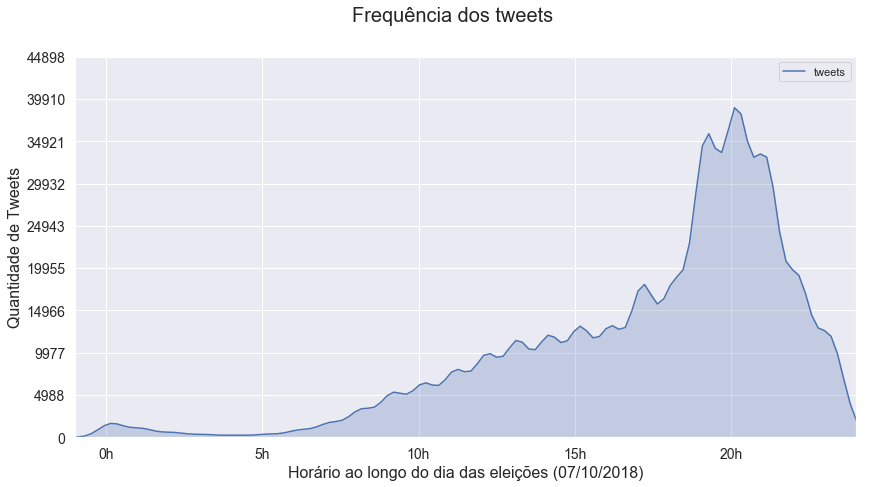

In [327]:
fig = sns.kdeplot(df_day['created_at_hour_float'], shade=True)

fig.figure.suptitle("Frequência dos tweets", fontsize=20)

plt.xlabel('Horário ao longo do dia das eleições (07/10/2018)', fontsize=16)
plt.xticks(fig.get_xticks(), list(map(lambda x: str(int(x)) + 'h', fig.get_xticks())), fontsize=14)
plt.xlim([-1, 24])

plt.ylabel('Quantidade de Tweets', fontsize=16)
plt.yticks(fig.get_yticks(), (fig.get_yticks() * df_day.shape[0]).astype(int), fontsize=14)

plt.legend(['tweets'])

now = str(int(datetime.now().timestamp()))
plt.savefig('plots/displot-{}.png'.format(now))

## 4. Analysis and plot generation by keywords

### 4.1. Using lineplots

In [314]:
def lineplot_by_keywords_timegap(keyword_matrix, min_gap=0, max_gap=24, title='', no_rt=False, only_rt=False):
    legends = []
    
    _df_day = df_day[(df_day['created_at_hour_int'] >= min_gap) & (df_day['created_at_hour_int'] <= max_gap)]
    
    if no_rt:
        _df_day = _df_day[_df_day['retweet_count'] == 0]
    elif only_rt:
        _df_day = _df_day[_df_day['retweet_count'] > 0]
     
    for keywords in keyword_matrix:
        sub_df = _df_day[_df_day['text'].str.contains('|'.join(keywords), regex=True, case=False)]
        fig = sns.lineplot(data=sub_df['created_at_hour_int'].value_counts(), size=2)
        legends.append(', '.join(keywords))
    
    fig.figure.suptitle('Ocorrências de palavras-chaves ' + title, fontsize = 20)
    
    plt.axvline(x=17, color='#A9A9A9', dashes=[4, 2])
    legends.append('17h - Fim do período de votação (exceto no Acre)')
    
    plt.axvline(x=19, color='#808080', dashes=[3, 2])
    legends.append('19h - Primeiro resultado das apurações')
    
    plt.axvline(x=20.85, color='#000000', dashes=[1, 2])
    legends.append('20h51m - Confirmação de segundo turno')

    plt.xlabel('Horário ao longo do dia das eleições (07/10/2018)', fontsize=16)
    plt.ylabel('Quantidade de tweets', fontsize=16)
    
    plt.xticks(fig.get_xticks(), list(map(lambda x: str(int(x)) + 'h', fig.get_xticks())), fontsize=14)
    plt.xlim([min_gap-0.5, max_gap-0.5])
    plt.yticks(fontsize=14)
    
    plt.legend(legends)
    
    now = str(int(datetime.now().timestamp()))
    plt.savefig('plots/displot-{}.png'.format(now))

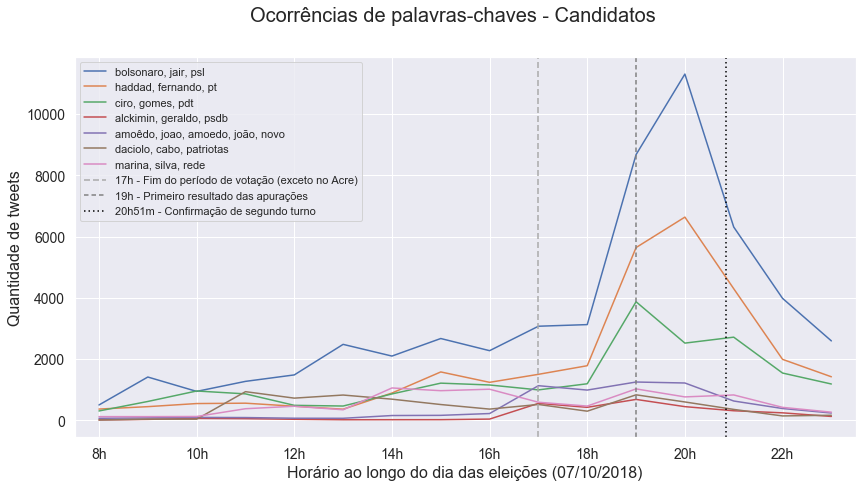

In [315]:
lineplot_by_keywords_timegap([
    ['bolsonaro', 'jair', 'psl'], 
    ['haddad', 'fernando', 'pt'],
    ['ciro', 'gomes', 'pdt'],
    ['alckimin', 'geraldo', 'psdb'],
    ['amoêdo', 'joao', 'amoedo', 'joão', 'novo'],
    ['daciolo', 'cabo', 'patriotas'],
    ['marina', 'silva', 'rede']
], title='- Candidatos', min_gap=8, max_gap=24)

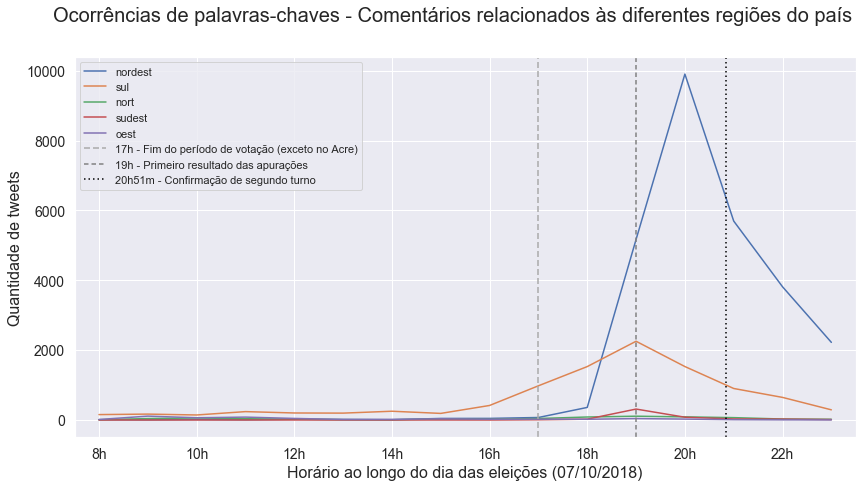

In [317]:
lineplot_by_keywords_timegap([
    ['nordest'],
    ['sul'],
    ['nort'],
    ['sudest'],
    ['oest']
], min_gap=8, max_gap=24, title='- Comentários relacionados às diferentes regiões do país')

### 4.2. Using python's counter

In [318]:
from collections import Counter
from functools import partial

def flatten_matrix(matrix):
    res = []
    for array in matrix:
        for item in array:
            res.append(item)
            
    return res

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

def filter_keywords(text, let_hashtags=False):
    res = []
    prohibited = ['rt', ' ']

    for word in text.split(' '):
        word = word.lower()
        if word not in prohibited and 'http' not in word:  
            if let_hashtags:
                filtered_word = ''.join(list(filter(lambda char: char.isalpha() or char == '#', list(word))))
            else:
                filtered_word = ''.join(list(filter(lambda char: char.isalpha(), list(word))))
            
            if(len(filtered_word) > 0):
                res.append(filtered_word)
        
    return res

def filter_hashtags(text):
    res = []

    for word in text.split(' '):
        word = word.lower()
        if len(word) > 0 and word[0] == '#':  
            res.append(word)
        
    return res

def generate_counter_timegap(min_gap=0, max_gap=24, no_rt=False, only_rt=False, hashtags_only=False):
    _df_day = df_day[(df_day['created_at_hour_int'] >= min_gap) & (df_day['created_at_hour_int'] <= max_gap)]
    
    if no_rt:
        _df_day = _df_day[_df_day['retweet_count'] == 0]
    elif only_rt:
        _df_day = _df_day[_df_day['retweet_count'] > 0]
    
    if hashtags_only:
        matrix = _df_day['text'].map(filter_hashtags)

    mapfunc = partial(filter_keywords, let_hashtags=hashtags_only)
    matrix = _df_day['text'].map(mapfunc)
        
    arr = flatten_matrix(matrix)
    
    return Counter(arr), arr

In [319]:
c, arr = generate_counter_timegap()

c.most_common(50)

[('de', 113527),
 ('o', 99309),
 ('eleições', 95968),
 ('e', 83716),
 ('a', 80182),
 ('que', 68107),
 ('no', 61124),
 ('em', 59878),
 ('do', 51627),
 ('não', 50673),
 ('é', 49602),
 ('bolsonaro', 47083),
 ('eleicoes', 46379),
 ('com', 33935),
 ('para', 31981),
 ('na', 31054),
 ('da', 30530),
 ('nordeste', 25245),
 ('turno', 21587),
 ('votos', 20816),
 ('urna', 20777),
 ('se', 20567),
 ('eu', 20494),
 ('ciro', 18730),
 ('urnas', 18368),
 ('haddad', 17820),
 ('as', 17608),
 ('brasil', 17373),
 ('das', 16456),
 ('um', 16271),
 ('vai', 15810),
 ('segundo', 15487),
 ('mais', 15441),
 ('dos', 13761),
 ('uma', 13248),
 ('os', 12809),
 ('bchartsnet', 12774),
 ('tem', 12398),
 ('por', 12263),
 ('pra', 12196),
 ('quem', 12187),
 ('são', 11896),
 ('candidato', 11818),
 ('pelo', 11804),
 ('folha', 11751),
 ('ao', 11498),
 ('só', 11396),
 ('votar', 11180),
 ('tsejusbr', 10931),
 ('nas', 10876)]

### 4.3. Using barplot

In [200]:
def barplot_by_keywords_timegap(keyword_matrix, min_gap=0, max_gap=24, no_rt=False, only_rt=False):
    _dict = {
        'keywords': [],
        'frequency': []
    }
    
    _df_day = df_day[(df_day['created_at_hour_int'] >= min_gap) & (df_day['created_at_hour_int'] <= max_gap)]
    
    if no_rt:
        _df_day = _df_day[_df_day['retweet_count'] == 0]
    elif only_rt:
        _df_day = _df_day[_df_day['retweet_count'] > 0]
     
    for keywords in keyword_matrix:
        sub_df = _df_day[_df_day['text'].str.contains('|'.join(keywords), regex=True, case=False)]
        _dict['keywords'].append(keywords[0])
        _dict['frequency'].append(sub_df.shape[0])
    
    final_df = pd.DataFrame(_dict)
    
    fig = sns.barplot(x='keywords', y='frequency', data=final_df)
    
    fig.figure.suptitle('Ocorrências de palavras-chaves relacionadas aos candidatos', fontsize = 16)

    plt.xlabel('candidatos', fontsize=14)
    plt.ylabel('ocorrências', fontsize=14)

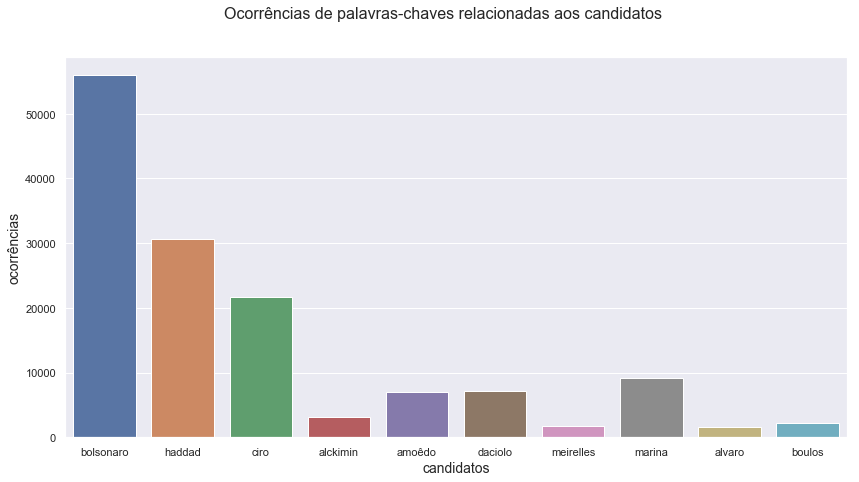

In [201]:
barplot_by_keywords_timegap([
    ['bolsonaro', 'jair', 'psl'], 
    ['haddad', 'fernando', 'pt'],
    ['ciro', 'gomes', 'pdt'],
    ['alckimin', 'geraldo', 'psdb'],
    ['amoêdo', 'joao', 'amoedo', 'joão', 'novo'],
    ['daciolo', 'cabo', 'patriotas'],
    ['meirelles', 'henrique', 'mdb'],
    ['marina', 'silva', 'rede'],
    ['alvaro', 'dias', 'podemos'],
    ['boulos', 'guilherme', 'psol']
])

### 4.4. Using wordclouds

In [202]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

stopwords = ['de', 'o', 'e', 'a', 'do', 'da', 'gome', 'htt', 'eleicoes', 'eleições', 'eleicoe', 'eleiçoe']

def generate_wordcloud_timegap(mask, max_words, max_font_size, bg_color, filename, min_gap=0, max_gap=24, no_rt=False, only_rt=False):
    
    c, text_arr = generate_counter_timegap(min_gap=min_gap, max_gap=max_gap, no_rt=no_rt, only_rt=only_rt)
    
    wordcloud = WordCloud(stopwords=stopwords, mask=mask, background_color=bg_color, mode="RGBA", 
                          max_words=max_words, max_font_size=max_font_size)
    wordcloud.generate(' '.join(text_arr))

    image_colors = ImageColorGenerator(mask)

    plt.figure(figsize=[20,12])
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
    plt.axis("off")

    plt.savefig('wordclouds/' + filename + '.png', format='png')

    plt.show()

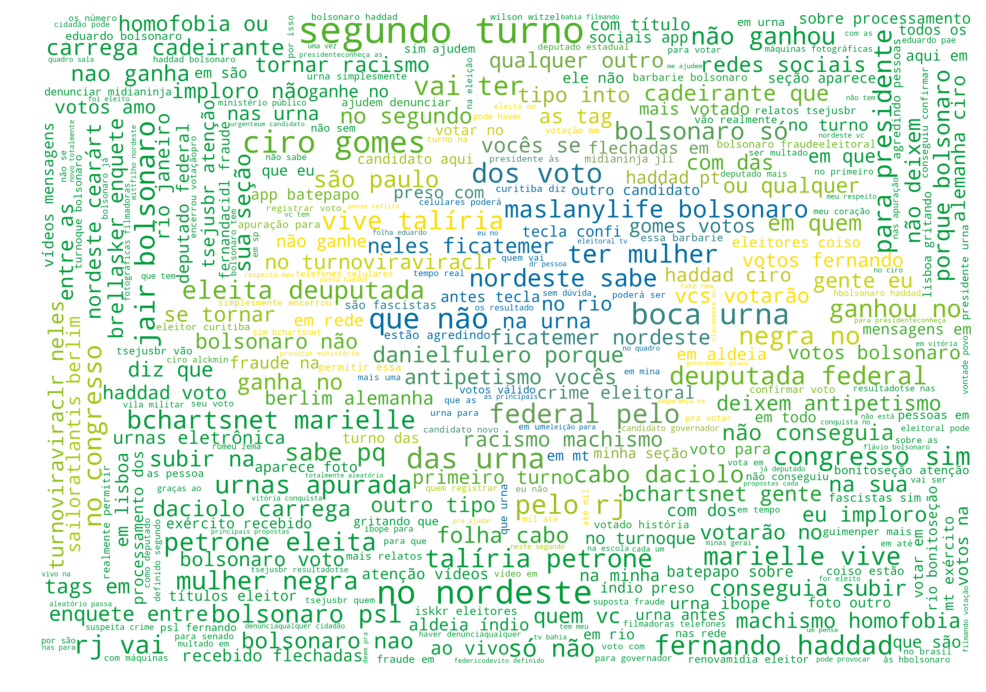

In [203]:
brazilian_flag_mask = np.array(Image.open('brazilian-flag.png'))

generate_wordcloud_timegap(brazilian_flag_mask, 350, 150, 'white', 'brazilian-flag-8-24', min_gap=8, max_gap=24)

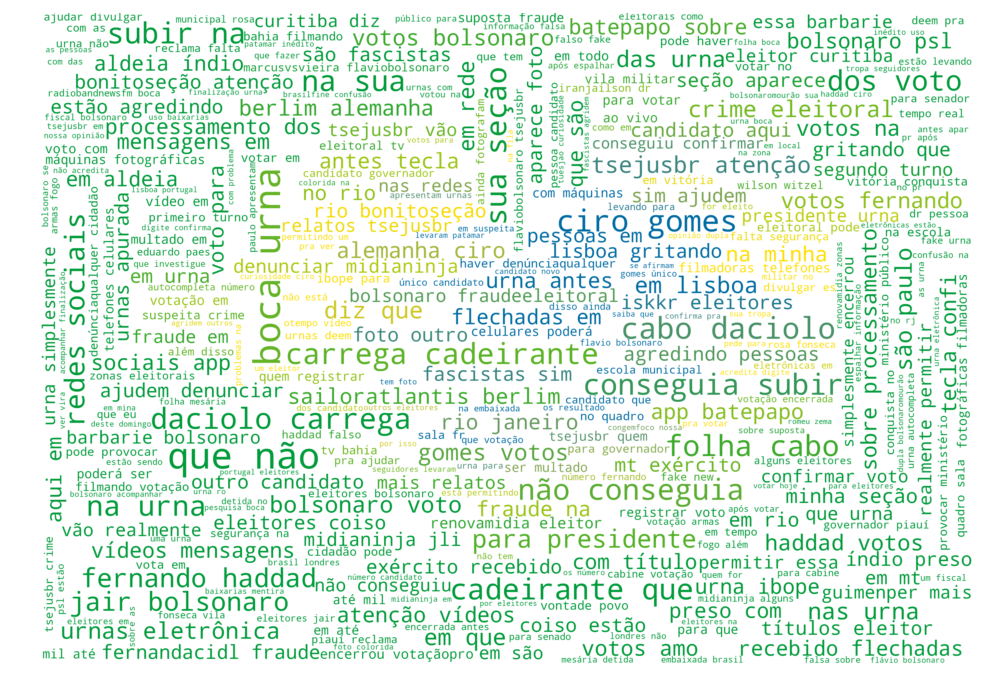

In [204]:
generate_wordcloud_timegap(brazilian_flag_mask, 350, 150, 'white', 'brazilian-flag-8-18', min_gap=8, max_gap=18)

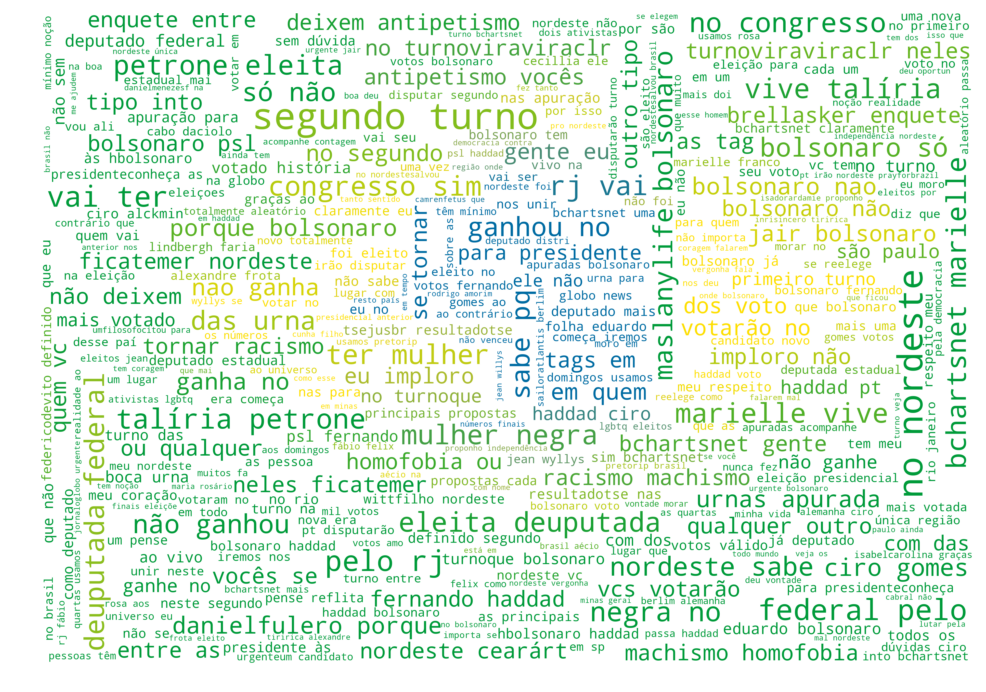

In [205]:
generate_wordcloud_timegap(brazilian_flag_mask, 350, 150, 'white', 'brazilian-flag-19-24', min_gap=19, max_gap=24)

## 5. Retweets analysis

### 5.1. Binary analysis using barplot

In [206]:
def rt_barplot_timegap(min_gap=0, max_gap=24):   
    _df_day = df_day[(df_day['created_at_hour_int'] >= min_gap) & (df_day['created_at_hour_int'] <= max_gap)]
    _df_day_rt = _df_day[_df_day['retweet_count'] > 0]
    
    _dict = {
        'x': ['RT', 'Não RT'],
        'y': [_df_day_rt.shape[0], _df_day.shape[0] - _df_day_rt.shape[0]]
    }
     
    final_df = pd.DataFrame(_dict)
    
    fig = sns.barplot(x='x', y='y', data=final_df)
    fig.figure.suptitle('Ocorrência de Retweets vs Não Retweets', fontsize = 16)

    plt.xlabel('')
    plt.ylabel('ocorrências', fontsize=14)

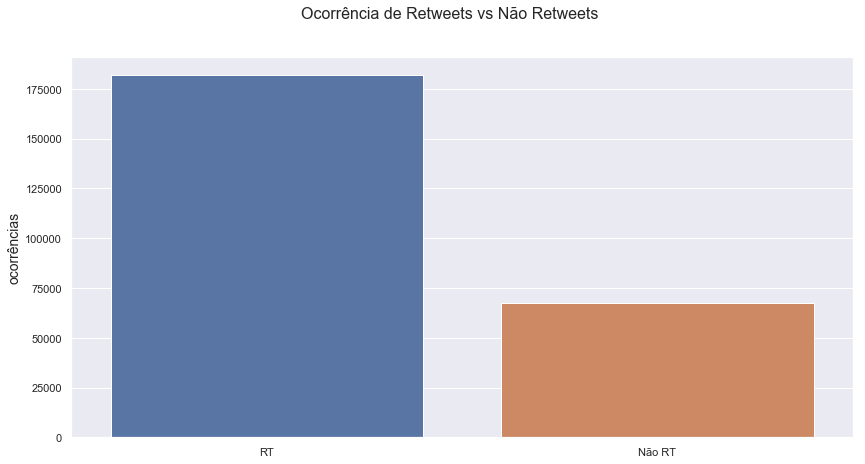

In [207]:
rt_barplot_timegap()

### 5.2. Top-k retweets analysis by keywords

In [208]:
def most_pop_rt_by_keywords(keywords=[], k=10):
    return df_day.sort_values(by='retweet_count', ascending=False) \
                 [df_day['text'].str.contains('|'.join(keywords), regex=True, case=False)] \
                 .drop_duplicates(subset=['text'], keep='first')[:k] \
                  [['retweet_count', 'text']]

most_pop_rt_by_keywords()

,retweet_count,text
256202,6526,RT @bchartsnet: MARIELLE VIVE: Talíria Petrone...
256152,5710,RT @maslanylife: Bolsonaro só não ganhou no no...
41189,5333,"RT @folha: ""Não dá para fingir que está tudo b..."
256129,4506,"RT @danielfulero: ""PORQUE BOLSONARO NAO GANHA ..."
256208,4449,RT @folha: Cabo Daciolo carrega cadeirante que...
256177,3699,"RT @bchartsnet: Gente, eu imploro, não deixem ..."
80857,3633,RT @TSEjusbr: Sabia que VOCÊ pode auditar a ur...
256168,3383,"RT @Brellasker: enquete entre as tags, em quem..."
149550,3334,RT @OJARDELITO: *PESQUISA - VÉSPERA DA ELEIÇÃO...
256149,2921,RT @sailoratlantis: Berlim - Alemanha #eleicoe...


In [209]:
most_pop_rt_by_keywords(['bolsonaro', 'jair', 'psl'])

,retweet_count,text
256152,5710,RT @maslanylife: Bolsonaro só não ganhou no no...
256129,4506,"RT @danielfulero: ""PORQUE BOLSONARO NAO GANHA ..."
256149,2921,RT @sailoratlantis: Berlim - Alemanha #eleicoe...
250902,2666,RT @Poder360: Confederação de associações come...
255420,1705,RT @congemfoco: Nossa opinião: a dupla Bolsona...
253461,1661,RT @guimenper: E mais relatos @TSEjusbr vão re...
129311,1139,RT @alisson10: E aí. Vai assistir de braços cr...
254426,1123,"RT @folha: 'Meu neto é branqueamento da raça',..."
255871,1116,RT @folha: Eduardo Bolsonaro já é o deputado m...
213382,1086,RT @TheInterceptBr: Conheça a surreal base de ...


In [210]:
most_pop_rt_by_keywords(['fernando', 'haddad', 'pt'])

,retweet_count,text
256149,2921,RT @sailoratlantis: Berlim - Alemanha #eleicoe...
133152,1936,RT @TheInterceptBr: A verdade é que os brasile...
252863,1818,RT @RICKO1102: Marcio França 1 x 0 João Doria\...
129311,1139,RT @alisson10: E aí. Vai assistir de braços cr...
213382,1086,RT @TheInterceptBr: Conheça a surreal base de ...
255667,883,RT @futmemes_: URGENTE!!!!\r\r\nUm candidato n...
255593,868,RT @otempo: Vídeo em que urna auto-completa nú...
38545,700,"RT @agencialupa: “Eu, praticamente, tripliquei..."
252667,667,RT @JornalOGlobo: URGENTE: Bolsonaro (PSL) e H...
155683,633,RT @sweetenerforgil: IBOPE 2018:\r\r\nBolsonar...


In [211]:
most_pop_rt_by_keywords(['nordest'])

,retweet_count,text
256152,5710,RT @maslanylife: Bolsonaro só não ganhou no no...
256129,4506,"RT @danielfulero: ""PORQUE BOLSONARO NAO GANHA ..."
256168,3383,"RT @Brellasker: enquete entre as tags, em quem..."
256211,1073,"RT @wittfilho: Nordeste, vc tem meu respeito e..."
256000,675,"RT @DanielMenezesF: Na boa, deu vontade de mor..."
256072,619,RT @IsadoraRDamie: Proponho a independência do...
256037,610,RT @InriSincero: Tiririca e Alexandre Frota e...
253664,585,RT @JansAraujo: A razão do Nordeste não eleger...
255920,558,RT @Carol_Alves88: Dá o Brasil pro Nordeste pq...
248063,523,RT @joaodeivison: o nordeste olhando pro resto...


## 7. Most active users (and bot) detection

In [212]:
df_day['handle'].value_counts()[:30]

.                                                     374
#Eleições2018 ⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠    278
Lucas                                                 243
Agência Brasil                                        213
Igor Navarro                                          204
Diário Catarinense                                    196
Ana                                                   193
ana                                                   188
maria                                                 179
EBC Na Rede                                           174
Rádio Bandeirantes                                    173
BandNews FM - Rio                                     169
lucas                                                 168
Bruno                                                 168
Matheus                                               167
O POVO Online                                         166
Gabriel                                               166
Record TV fãs 

## 8. Hashtag analysis

### 8.1. Using python's counter

In [213]:
def filter_hashtags(text):
    res = []

    for word in text.split(' '):
        word = word.lower()
        if len(word) > 0 and word[0] == '#':  
            res.append(word)
        
    return res

def generate_hashtag_counter_timegap(min_gap=0, max_gap=24, no_rt=False, only_rt=False):
    _df_day = df_day[(df_day['created_at_hour_int'] >= min_gap) & (df_day['created_at_hour_int'] <= max_gap)]
    
    if no_rt:
        _df_day = _df_day[_df_day['retweet_count'] == 0]
    elif only_rt:
        _df_day = _df_day[_df_day['retweet_count'] > 0]
    
    matrix = _df_day['text'].map(filter_hashtags)
    arr = flatten_matrix(matrix)
    
    return Counter(arr), arr

In [224]:
ht_c, ht_arr = generate_hashtag_counter_timegap()
ht_c.most_common(100)

[('#eleições2018', 77469),
 ('#eleicoes2018', 38252),
 ('#viraviraclr0', 5208),
 ('#g1', 4780),
 ('#ficatemer', 4775),
 ('#17neles', 4685),
 ('#eleicoes2018\r\r\n\r\r\n1.', 2750),
 ('#eleiçoes2018', 2620),
 ('#elenão', 2366),
 ('#elenao', 2191),
 ('#bolsonaro', 1946),
 ('#eleições2018:', 1740),
 ('#lisboa', 1657),
 ('#fraudeeleitoral', 1628),
 ('#curitiba', 1421),
 ('#ciro12', 1298),
 ('#resultadotse', 1296),
 ('#eleições2018\u2060', 1274),
 ('#folha', 1198),
 ('#fake', 1167),
 ('#ele…', 1128),
 ('#…', 1061),
 ('#prayforbrazil', 971),
 ('#elenunca', 903),
 ('#viraviracir0', 891),
 ('#brasil', 888),
 ('#eleições2018…', 825),
 ('#urna', 808),
 ('#cbnaseleições', 742),
 ('#fraudenasurnaseletronicas', 712),
 ('#eleiçõesopovo', 697),
 ('#eleiçõe…', 684),
 ('#eleiçõessjcc', 639),
 ('#vira…', 598),
 ('#eleicoes2018…', 564),
 ('#eleicoes2…', 552),
 ('#fraudenasurnas', 547),
 ('#euvotobolsonaro', 498),
 ('#urgente', 470),
 ('#eleições2018.', 463),
 ('#nordeste', 458),
 ('#direitaunida\r\r\nse',

### 8.2. Using lineplots

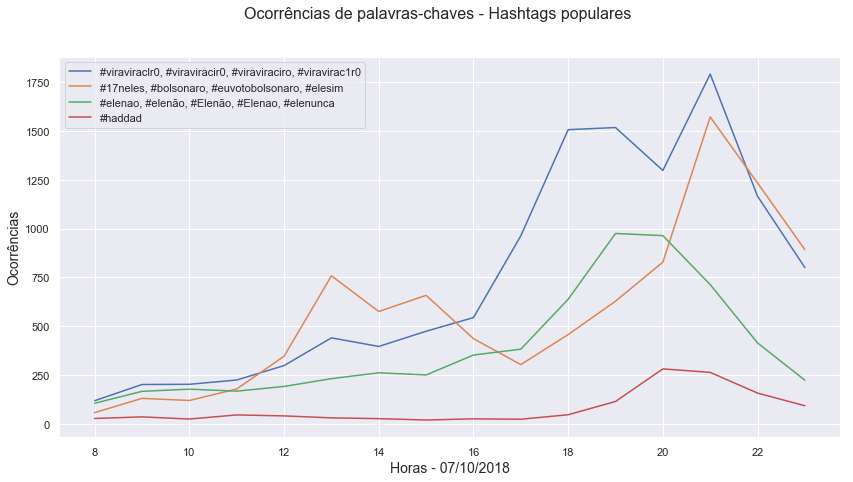

In [216]:
lineplot_by_keywords_timegap([
    ['#viraviraclr0', '#viraviracir0', '#viraviraciro', '#viravirac1r0'],
    ['#17neles', '#bolsonaro', '#euvotobolsonaro', '#elesim'],
    ['#elenao', '#elenão', '#Elenão', '#Elenao', '#elenunca'],
    ['#haddad']
], min_gap=8, max_gap=24, title='- Hashtags populares')

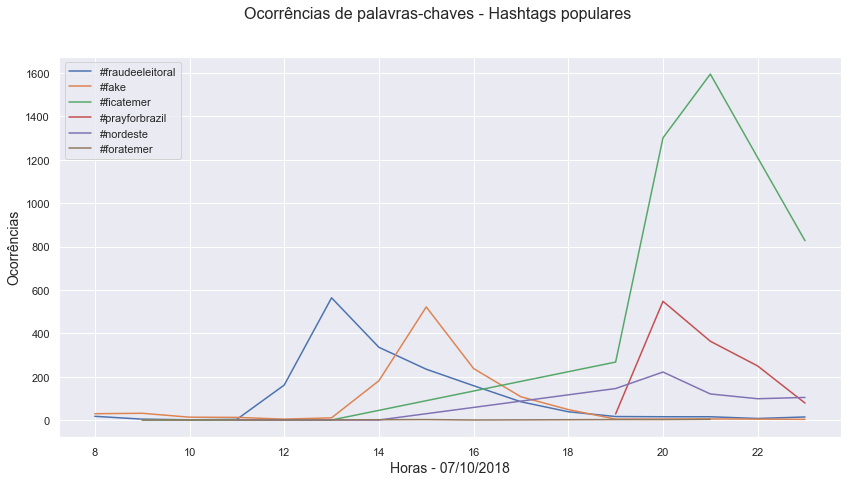

In [217]:
lineplot_by_keywords_timegap([
    ['#fraudeeleitoral'],
    ['#fake'],
    ['#ficatemer'],
    ['#prayforbrazil'],
    ['#nordeste'],
    ['#foratemer']
], min_gap=8, max_gap=24, title='- Hashtags populares')
    